<a href="https://colab.research.google.com/github/LinaMariaCastro/curso-ia-para-economia/blob/main/clases/5_Aprendizaje_supervisado/6_Clases_Desbalanceadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligencia Artificial con Aplicaciones en Economía I**

- 👩‍🏫 **Profesora:** [Lina María Castro](https://www.linkedin.com/in/lina-maria-castro)  
- 📧 **Email:** [lmcastroco@gmail.com](mailto:lmcastroco@gmail.com)  
- 🎓 **Universidad:** Universidad Externado de Colombia - Facultad de Economía

# 🍰 **Manejo de clases desbalanceadas y selección del mejor modelo**

**Objetivos de Aprendizaje**

1. Abordar un problema práctico de clases desbalanceadas usando diferentes modelos ya vistos en clase y aprendiendo uno nuevo: XGBoost.
2. Encontrar el mejor modelo usando Validación Cruzada y Búsqueda de Grilla.
3. Realizar una evaluación final del modelo seleccionado con el conjunto de prueba (`test set`).

**Dataset:** `WA_Fn-UseC_-Telco-Customer-Churn.csv`

**Modelos a explorar:**
1.  Regresión Logística (con `class_weight`)
2.  Árbol de Decisión (con `class_weight`)
3.  Random Forest (con `class_weight`)
4.  XGBoost (con `scale_pos_weight`)

**Métrica de Evaluación Principal:** AUC-ROC.

## 1. Importación de Librerías y Carga de Datos

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas y Tuning
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

### Mejorar visualización de dataframes y gráficos

In [2]:
# Que muestre todas las columnas
pd.options.display.max_columns = None
# En los dataframes, mostrar los float con dos decimales
pd.options.display.float_format = '{:,.2f}'.format

# Configuraciones para una mejor visualización
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### Carga de datos

In [3]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/2025_ii_curso_ia_economia/datasets'

In [5]:
# Para establecer el directorio de los archivos
os.chdir(path)

In [6]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Explicación de las variables:**

- customerID: Identificador único para cada cliente.
- gender: Género del cliente (Masculino/Femenino).
- SeniorCitizen: Indica si el cliente es un ciudadano mayor (adulto mayor) (1 = Sí, 0 = No).
- Partner: Indica si el cliente tiene pareja (Sí/No).
- Dependents: Indica si el cliente tiene dependientes (Sí/No).
- tenure: Número de meses que el cliente ha estado con la compañía (Antigüedad).
- PhoneService: Si el cliente está suscrito al servicio telefónico (Sí/No).
- MultipleLines: Indica si el cliente tiene múltiples líneas telefónicas (Sí/No/Sin servicio telefónico).
- InternetService: Tipo de servicio de internet suscrito (DSL, Fibra óptica, No).
- OnlineSecurity: Indica si el cliente tiene el complemento de seguridad en línea (Sí/No/Sin servicio de internet).
- OnlineBackup: Indica si el cliente usa el servicio de respaldo en línea (Sí/No/Sin servicio de internet).
- DeviceProtection: Indica si el cliente tiene protección de dispositivos (Sí/No/Sin servicio de internet).
- TechSupport: Indica si el cliente tiene suscripción a soporte técnico (Sí/No/Sin servicio de internet).
- StreamingTV: Indica si el cliente hace streaming de TV (Sí/No/Sin servicio de internet).
- StreamingMovies: Indica si el cliente hace streaming de películas (Sí/No/Sin servicio de internet).
- Contract: Tipo de contrato (Mes a mes, Un año, Dos años).
- PaperlessBilling: Si el cliente usa facturación electrónica (sin papel) (Sí/No).
- PaymentMethod: Método de pago usado por el cliente (Cheque electrónico, Cheque enviado por correo, Transferencia bancaria, Tarjeta de crédito).
- MonthlyCharges: El monto cobrado al cliente mensualmente (Cargos mensuales).
- TotalCharges: El monto total cobrado al cliente durante su antigüedad (Cargos totales).
- Churn: Indica si el cliente ha cancelado el servicio (Sí/No). --> **Esta es la variable objetivo**

## 2. Análisis Exploratorio (EDA) y Preprocesamiento
Nos enfocaremos en los pasos esenciales de limpieza y preparación para los modelos.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 2.1. Limpieza de Datos

**Observaciones:**
1.  `TotalCharges` es un `object` y debe ser numérico. Contiene espacios en blanco.
2.  `customerID` no es una característica predictiva y debe ser eliminada.
3.  La columna objetivo `Churn` es 'Yes'/'No' y debe ser 0/1.

In [8]:
# 1. Convertir TotalCharges a numérico (los errores se convierten en NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Manejar NaNs (en este caso, son pocos, así que los eliminamos)
df.dropna(inplace=True)

# 2. Eliminar customerID
df = df.drop('customerID', axis=1)

# 3. Mapear Churn
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,"1,889.50",0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,"1,840.75",0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### 2.2. El Problema: Clases Desbalanceadas

Verifiquemos la distribución de nuestra variable objetivo.

Churn
0    5163
1    1869
Name: count, dtype: int64

Porcentaje de Fuga (Churn): 26.58%


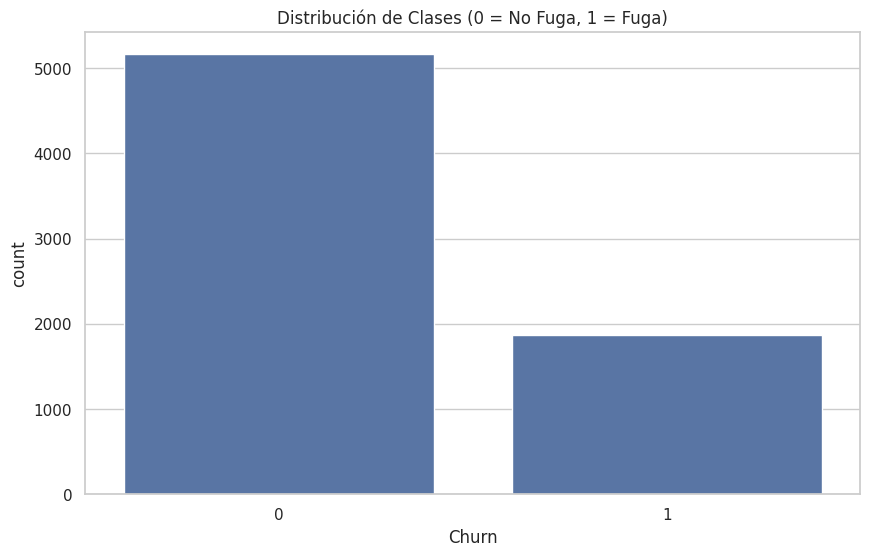

In [9]:
churn_counts = df['Churn'].value_counts()
print(churn_counts)
print(f"\nPorcentaje de Fuga (Churn): {churn_counts[1] / churn_counts.sum() * 100:.2f}%")

sns.countplot(x='Churn', data=df)
plt.title('Distribución de Clases (0 = No Fuga, 1 = Fuga)')
plt.show()

Un modelo que siempre diga 'No Fuga' tendría una exactitud (accuracy) del 73.49%. ¡Sería inútil para el negocio, ya que no identifica a ningún cliente en riesgo! Por esto, usaremos AUC-ROC como nuestra métrica principal.

### 2.3. Definición de X/y e Identificación de Columnas

Primero, separamos `X` e `y`. Luego, identificamos qué columnas son numéricas (para escalar) y cuáles son categóricas (para aplicar One-Hot Encoding).

In [10]:
# Separar X (features) e y (target)
X = df.drop('Churn', axis=1)
y = df['Churn']

In [11]:
# Identificar columnas numéricas y categóricas
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Luego, defines cat_cols como "todas las columnas en X que NO están en num_cols"
cat_cols = [col for col in X.columns if col not in num_cols]

print(f"Columnas Numéricas ({len(num_cols)}): {num_cols}")
print(f"Columnas Categóricas ({len(cat_cols)}): {cat_cols}")

Columnas Numéricas (3): ['tenure', 'MonthlyCharges', 'TotalCharges']
Columnas Categóricas (16): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


### 2.4. División de Datos (Train/Test Split)

**MUY IMPORTANTE:** Dividimos los datos **ANTES** de aplicar cualquier preprocesamiento (escalado, encoding). Esto evita la fuga de datos.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"\nDistribución de Fuga en y_train: {y_train.mean():.2f}")
print(f"Distribución de Fuga en y_test: {y_test.mean():.2f}")

Forma de X_train: (5625, 19)
Forma de X_test: (1407, 19)

Distribución de Fuga en y_train: 0.27
Distribución de Fuga en y_test: 0.27


### 2.5. Creación del `ColumnTransformer` (Preprocesador)

Ahora creamos un "preprocesador" que sabe qué hacer con cada tipo de columna:
1.  **Transformador Numérico:** Aplica `StandardScaler` a las columnas `num_cols`.
2.  **Transformador Categórico:** Aplica `OneHotEncoder` a las columnas `cat_cols`.
    - `drop='first'` evita la multicolinealidad, tal como lo hacía `pd.get_dummies(drop_first=True)`.
    - `handle_unknown='ignore'` evita errores si una categoría aparece en el set de prueba pero no en el de entrenamiento.

In [13]:
# Crear los transformadores
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='passthrough' # Dejar pasar columnas no especificadas (aunque no debería haber)
)

### 2.6. Aplicar el Preprocesador

Usamos `.fit_transform()` en el set de entrenamiento y solo `.transform()` en el set de prueba.

In [14]:
# Ajustar y transformar X_train
X_train_processed = preprocessor.fit_transform(X_train)

# Solo transformar X_test
X_test_processed = preprocessor.transform(X_test)

print("Datos de entrenamiento procesados.")
print(f"Forma de X_train_processed: {X_train_processed.shape}")
print("\nDatos de prueba procesados.")
print(f"Forma de X_test_processed: {X_test_processed.shape}")

# Los modelos ahora usarán X_train_processed y X_test_processed.
# Estos son arrays de NumPy, no DataFrames.

Datos de entrenamiento procesados.
Forma de X_train_processed: (5625, 30)

Datos de prueba procesados.
Forma de X_test_processed: (1407, 30)


## 3. Búsqueda de los Mejores Hiperparámetros

Ahora, buscaremos los mejores hiperparámetros para cada modelo usando `GridSearchCV`. Usamos `cv=5` (Validación Cruzada de 5 pliegues) y `scoring='roc_auc'`.

**Nota:** A partir de ahora, usaremos `X_train_processed` y `y_train` para todo el entrenamiento y validación.

### Modelo 1: Regresión Logística (con `class_weight`)

Usamos `class_weight='balanced'` para que el modelo penalice más los errores en la clase minoritaria.

En esencia, esa línea de código le dice al algoritmo: "No todos los errores cuestan lo mismo. Quiero que te obsesiones con acertar a la clase minoritaria (ej. 'Fuga'), y te penalizaré mucho más cada vez que te equivoques con ella."

El modelo se da cuenta de que cometer un Falso Negativo es mucho más costoso que cometer un Falso Positivo .

**Matriz de Confusión**

![Matriz de Confusión](https://drive.google.com/uc?id=1sNmqMXzJ3XhMR7wNgnnmTv4sAxeSGZIo)

**Optimizaremos el hiperparámetro `C`.**

C controla la fuerza de la regularización o "penalización" que se le aplica al modelo para evitar que se vuelva demasiado complejo y memorice los datos (es decir, para evitar el overfitting).

Un valor de C pequeño (ej. 0.01): Significa una regularización FUERTE. Está penalizando mucho al modelo, forzándolo a ser más simple.

Un valor de C grande (ej. 10): Significa una regularización DÉBIL. Está "soltando la correa" y permitiendo que el modelo se ajuste a los datos con más libertad y complejidad.

In [15]:
print("Iniciando GridSearch para Regresión Logística...")
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000),
    param_grid=param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1, # Usar todos los procesadores
    verbose=1
)

grid_lr.fit(X_train_processed, y_train)

print(f"\nMejor Puntuación (AUC-ROC) en CV: {grid_lr.best_score_:.4f}")
print(f"Mejores Hiperparámetros: {grid_lr.best_params_}")

Iniciando GridSearch para Regresión Logística...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Mejor Puntuación (AUC-ROC) en CV: 0.8458
Mejores Hiperparámetros: {'C': 10}


### Modelo 2: Árbol de Decisión (con `class_weight`)

Usamos `class_weight='balanced'` para que el modelo penalice más los errores en la clase minoritaria (Fuga).

In [16]:
print("Iniciando GridSearch para Decision Tree...")
param_grid_dt = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [10, 20, 50]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1, # Usar todos los procesadores
    verbose=1
)

grid_dt.fit(X_train_processed, y_train)

print(f"\nMejor Puntuación (AUC-ROC) en CV: {grid_dt.best_score_:.4f}")
print(f"Mejores Hiperparámetros: {grid_dt.best_params_}")

Iniciando GridSearch para Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Mejor Puntuación (AUC-ROC) en CV: 0.8330
Mejores Hiperparámetros: {'max_depth': 7, 'min_samples_leaf': 50}


### Modelo 3: Random Forest (con `class_weight`)

Random Forest es un ensamble de árboles, lo que lo hace más robusto. También usamos `class_weight='balanced'`.

In [17]:
print("Iniciando GridSearch para Random Forest...")
# NOTA: Reducimos la grilla para que se ejecute más rápido en clase
# En un proyecto real, probaríamos más n_estimators y max_depth
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_processed, y_train)

print(f"\nMejor Puntuación (AUC-ROC) en CV: {grid_rf.best_score_:.4f}")
print(f"Mejores Hiperparámetros: {grid_rf.best_params_}")

Iniciando GridSearch para Random Forest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Mejor Puntuación (AUC-ROC) en CV: 0.8444
Mejores Hiperparámetros: {'max_depth': 10, 'n_estimators': 200}


### Modelo 4: XGBoost (con `scale_pos_weight`)

**XGBoost (o Extreme Gradient Boosting)** es una implementación optimizada del Gradient Boosting (GBM).

XGBoost es más rápido, más preciso y tiene más protecciones contra el sobreajuste.

Diferencias entre GBM vs. XGBoost:

- **Regularización:** XGBoost incluye regularización L1 (Lasso) y L2 (Ridge) en su función de costo. Esto penaliza la complejidad de los árboles, combatiendo el sobreajuste (overfitting) de manera nativa, algo que el GBM estándar no hace tan eficientemente.

- **Velocidad y Eficiencia:** XGBoost está diseñado para ser computacionalmente eficiente. Utiliza paralelización (para construir los árboles más rápido) y maneja los recursos del sistema de forma más inteligente.

- **Manejo de Clases Desbalanceadas:** XGBoost introduce el hiperparámetro "scale_pos_weight". Este es su mecanismo para manejar clases desbalanceadas, permitiéndonos "aumentar la importancia" de la clase minoritaria sin modificar los datos.

Para el manejo de clases desbalanceadas, vamos a usar: `scale_pos_weight`. Este le dice al modelo que dé más importancia a los errores de la clase positiva (Fuga).

El valor ideal es: `(conteo de la clase mayoritaria) / (conteo de la clase minoritaria)`.

Por defecto, XGBoost (como la mayoría de los modelos) le da la misma importancia a cada error.

- Error tipo I: Predecir "Fuga" cuando el cliente NO se va (Falso Positivo).
- Error tipo II: Predecir "No Fuga" cuando el cliente SÍ se va (Falso Negativo).

Ambos errores le cuestan al modelo "1 punto" de penalización.

Con clases debalanceadas, el modelo aprende rápido que la forma más fácil de minimizar su penalización total es simplemente volverse muy bueno prediciendo 'No Fuga'. Es "barato" equivocarse en la minoría.

"scale_pos_weight" permite decirle al modelo que Los errores no son iguales. El Error tipo II (Falso Negativo) es mucho peor para el negocio.

Al establecer scale_pos_weight, cambias la penalización:

- Penalización por un Falso Positivo (equivocarse en la mayoría) = 1 punto.

- Penalización por un Falso Negativo (equivocarse en la minoría) = scale_pos_weight puntos (en este caso, 2,76 puntos).

In [18]:
# Calcular scale_pos_weight para el set de ENTRENAMIENTO
counts = y_train.value_counts()
scale_pos_weight = counts[0] / counts[1]
print(f"El valor de scale_pos_weight es: {scale_pos_weight:.2f}")

El valor de scale_pos_weight es: 2.76


Adicionalmente, vamos a optimizar los siguientes hiperparámetros:

- n_estimators: Es el número de árboles (modelos) que el algoritmo va a construir en secuencia.
- learning_rate (Tasa de Aprendizaje): Controla cuánto contribuye cada nuevo árbol al ensamble final.
- max_depth (Profundidad Máxima): Controla la profundidad máxima de cada árbol individual.

In [19]:
print("Iniciando GridSearch para XGBoost...")
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid_xgb = GridSearchCV(
    XGBClassifier(random_state=42,
                  objective='binary:logistic',
                  eval_metric='logloss',
                  use_label_encoder=False,
                  scale_pos_weight=scale_pos_weight), # ¡El parámetro clave!
    param_grid=param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_processed, y_train)

print(f"\nMejor Puntuación (AUC-ROC) en CV: {grid_xgb.best_score_:.4f}")
print(f"Mejores Hiperparámetros: {grid_xgb.best_params_}")

Iniciando GridSearch para XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Mejor Puntuación (AUC-ROC) en CV: 0.8464
Mejores Hiperparámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


## 4. Comparación de Modelos

Ahora, comparemos el mejor rendimiento (AUC-ROC medio de la validación cruzada) de cada uno de nuestros modelos.

In [20]:
# Recopilar los resultados
results = {
    'Modelo': [
        'Regresión Logística',
        'Árbol de Decisión',
        'Random Forest',
        'XGBoost'
    ],
    'Mejor_AUC_ROC_CV': [
        grid_lr.best_score_,
        grid_dt.best_score_,
        grid_rf.best_score_,
        grid_xgb.best_score_
    ]
}

df_results = pd.DataFrame(results).sort_values(by='Mejor_AUC_ROC_CV', ascending=False)

print("Resultados de la Comparación de Modelos (basado en CV en el set de TRAIN):")
display(df_results.style.format({'Mejor_AUC_ROC_CV': '{:.4f}'}))

Resultados de la Comparación de Modelos (basado en CV en el set de TRAIN):


,Modelo,Mejor_AUC_ROC_CV
3,XGBoost,0.8464
0,Regresión Logística,0.8458
2,Random Forest,0.8444
1,Árbol de Decisión,0.8330


**Conclusión de la Selección:**

Basado en nuestra validación cruzada, el modelo **XGBoost** es el ganador. Tiene la mejor puntuación de `roc_auc` media en los pliegues de validación.

Ahora, y **solo ahora**, tomaremos este modelo campeón, con sus mejores hiperparámetros, y lo evaluaremos en nuestro conjunto de prueba (`X_test_processed`) que hemos mantenido oculto.

## 5. Evaluación Final del Modelo Campeón en el Conjunto de Prueba

¡El momento de la verdad! ¿Cómo generaliza nuestro mejor modelo a datos completamente nuevos?

In [22]:
# Seleccionamos el mejor modelo (el estimador ya entrenado por GridSearchCV)

# Diccionario de modelos para selección automática
model_map = {
    'Regresión Logística': grid_lr.best_estimator_,
    'Árbol de Decisión': grid_dt.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_
}

winner_name = df_results.iloc[0]['Modelo']
best_model = model_map[winner_name]

print(f"Evaluando el modelo campeón: {type(best_model).__name__}")

# 1. Realizar predicciones en X_test_processed
y_pred_test = best_model.predict(X_test_processed)
y_proba_test = best_model.predict_proba(X_test_processed)[:, 1] # Probabilidades para la clase 1 (Fuga)

Evaluando el modelo campeón: XGBClassifier


### 5.1. Reporte de Clasificación y Matriz de Confusión

Aquí vemos el rendimiento en términos de **Precisión** y **Recall**.

--- Reporte de Clasificación (Test Set) ---
              precision    recall  f1-score   support

 No Fuga (0)       0.91      0.70      0.79      1033
    Fuga (1)       0.50      0.81      0.62       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.70      1407
weighted avg       0.80      0.73      0.75      1407

--- Matriz de Confusión (Test Set) ---


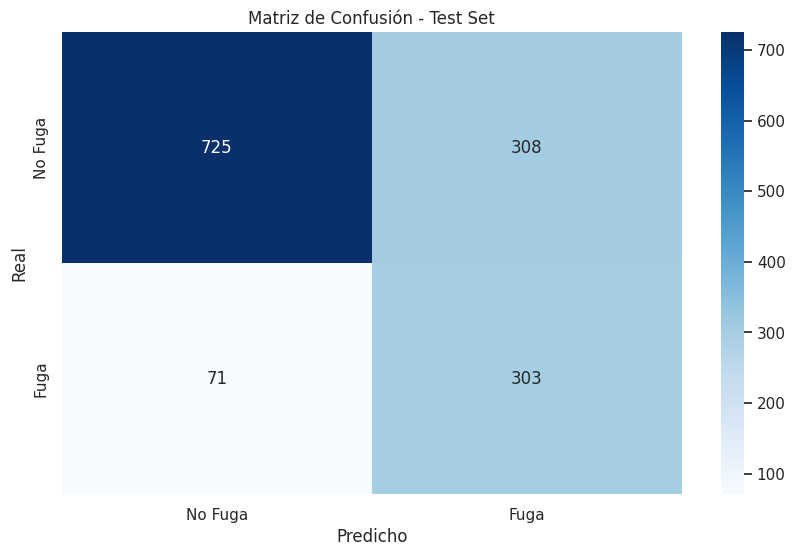

In [23]:
print("--- Reporte de Clasificación (Test Set) ---")
print(classification_report(y_test, y_pred_test, target_names=['No Fuga (0)', 'Fuga (1)']))

print("--- Matriz de Confusión (Test Set) ---")
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fuga', 'Fuga'], yticklabels=['No Fuga', 'Fuga'])
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión - Test Set')
plt.show()

**Análisis de la Matriz:**
* **Verdaderos Negativos (VN):** (Arriba-Izquierda) Clientes que predijimos que NO se irían, y NO se fueron. ¡Bien!
* **Falsos Positivos (FP):** (Arriba-Derecha) Clientes que predijimos que SÍ se irían, pero se quedaron. (Costo: Invertir en retener a un cliente feliz).
* **Falsos Negativos (FN):** (Abajo-Izquierda) Clientes que predijimos que NO se irían, pero SÍ se fueron. **(¡El peor error económico!)**
* **Verdaderos Positivos (VP):** (Abajo-Derecha) Clientes que predijimos que SÍ se irían, y SÍ se fueron. ¡Éxito! (El **Recall** se enfoca en maximizar esto).

### 5.2. Curva ROC y Puntuación AUC (Test Set)

Esta es la evaluación final de nuestra métrica objetivo.

Puntuación AUC-ROC en el Test Set: 0.8409


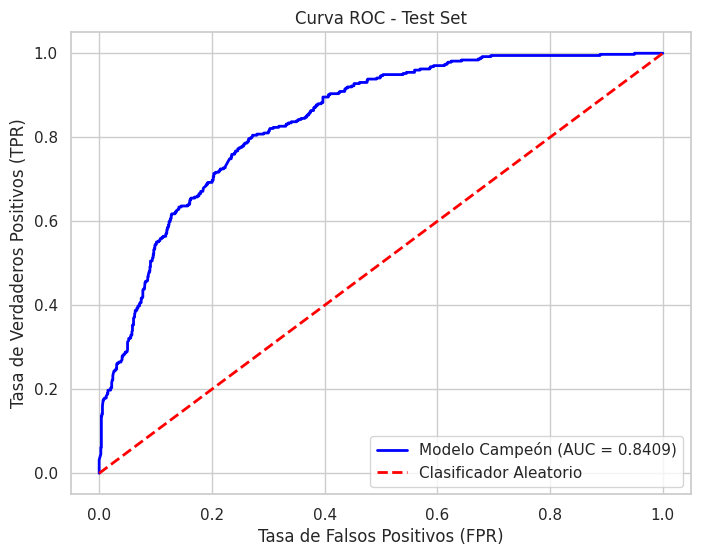

In [24]:
auc_test = roc_auc_score(y_test, y_proba_test)
print(f"Puntuación AUC-ROC en el Test Set: {auc_test:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Modelo Campeón (AUC = {auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Test Set')
plt.legend(loc='lower right')
plt.show()

## 6. Discusión Final y Próximos Pasos

1.  **¿Cumplimos el objetivo?** Sí, hemos construido un modelo que es significativamente mejor que el azar (AUC > 0.5) y que la exactitud ingenua. Su puntuación de AUC en el *test set* es cercana a su puntuación de validación cruzada, lo que indica que **no hemos sobreajustado** y el modelo generaliza bien.

2.  **¿Qué le decimos al negocio?**
    * Nuestro modelo puede identificar correctamente al *81%** de los clientes que realmente se van.
    * Cuando predecimos que un cliente se va a ir, acertamos el **50%** de las veces.
    * **Acción:** El negocio puede ahora tomar la lista de clientes con alta probabilidad de fuga (predicha por el modelo) y aplicar estrategias de retención *antes* de que se vayan, ahorrando millones.

3.  **¿Qué sigue?** Podemos usar la **Importancia de Características** del modelo para entender *por qué* los clientes se van.

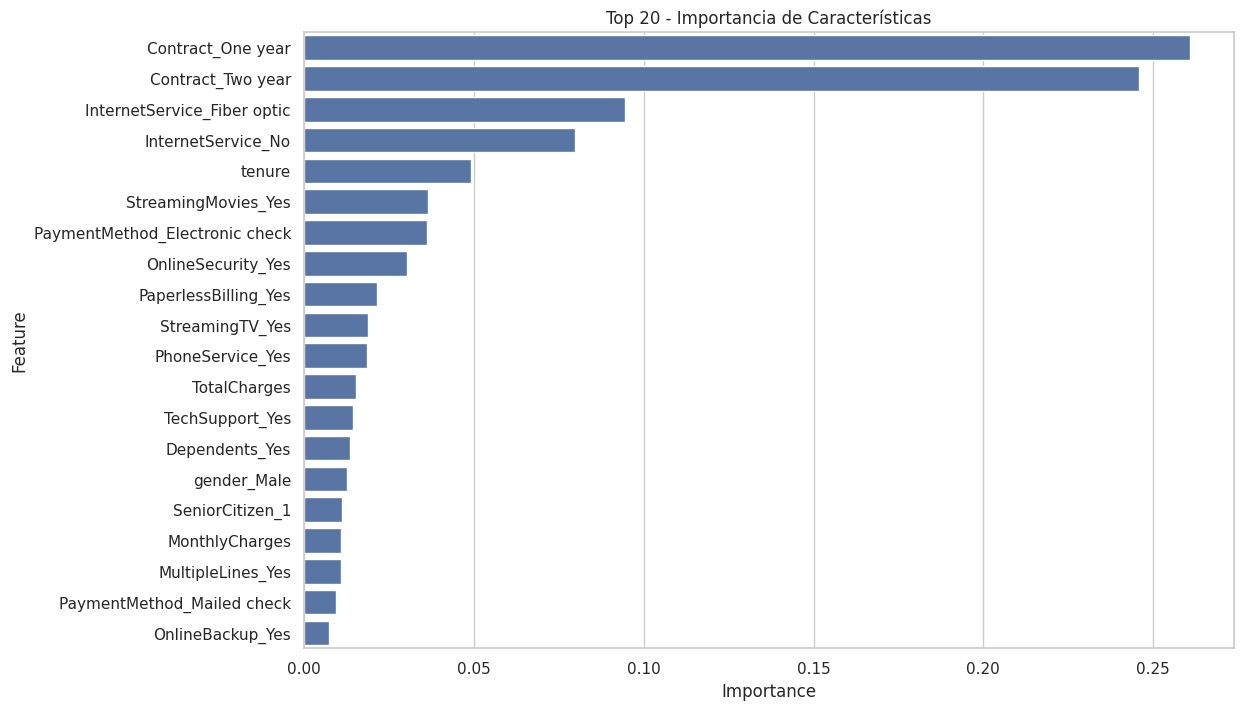

In [25]:
# Extraer los nombres de las características del preprocesador

# Obtener los nombres de las características categóricas codificadas
cat_features_out = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
# Combinar con las características numéricas (que no cambian de nombre)
feature_names = list(num_cols) + list(cat_features_out)

# Mostrar importancia de características (si el modelo no es LogReg)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_

    df_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Mostrar el Top 20
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=df_importances.head(20), orient='h')
    plt.title('Top 20 - Importancia de Características')
    plt.show()

# Mostrar coeficientes (si el modelo es LogReg)
elif hasattr(best_model, 'coef_'):
    importances = best_model.coef_[0]

    df_importances = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': importances
    })

    # Tomar el valor absoluto para ordenar, pero mostrar el coeficiente real
    df_importances['Abs_Coefficient'] = np.abs(df_importances['Coefficient'])
    df_importances = df_importances.sort_values(by='Abs_Coefficient', ascending=False)

    # Mostrar el Top 20
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=df_importances.head(20), orient='h')
    plt.title('Top 20 - Coeficientes del Modelo (Importancia)')
    plt.show()